In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import random

# Define the stock and time period
ticker = "VOO"
period = "1y"  # 1 year of data

# Pull data
df = yf.download(ticker, period=period)

# Calculate Moving Averages (75-day)
df['EMA_75'] = df['Close'].ewm(span=100, adjust=False).mean()

# Calculate Price Returns (Daily Percentage Change)
df['Price_Return'] = df['Close'].pct_change() * 100

df = df[['Close', 'Volume', 'EMA_75', 'Price_Return']]

# Drop NaN values (caused by moving average calculations)
df.dropna(inplace=True)
df.reset_index(inplace=True)

print(df.shape)
print(df)

# Define Labeling Function
def label(pr):
    # Label as 1 (Buy) if Price_Return > 1%
    # Label as -1 (Sell) if Price_Return < -1%
    # Otherwise, 0 (Hold)
    if pr > 1:  # This should work fine
        return 2
    elif pr < -1:
        return 0
    else:
        return 1

print(df.columns)
# Apply the label function correctly to each row
labels = []
for index, row in df.iterrows():
    # Extract the value as a single float
    pr = row['Price_Return']['']
    temp = label(pr)
    labels.append(temp)

df['Label'] = labels

print(df.head(3))  # Check the output

df = df[['Close', 'Volume', 'EMA_75', 'Price_Return', 'Label']]

# ---------------------- Data Preparation ----------------------

# Standardize data
X = df[['Close', 'Volume', 'EMA_75', 'Price_Return']].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std  # Standardization

# Target variable
y = df['Label'].to_numpy()

# ----------------- Splitting Data 80/20----------------

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


(250, 5)
Price        Date       Close   Volume      EMA_75 Price_Return
Ticker                    VOO      VOO                         
0      2024-05-15  480.460175  4399500  474.792178     1.218195
1      2024-05-16  479.542450  3347400  474.886243    -0.191010
2      2024-05-17  480.252960  3274000  474.992515     0.148164
3      2024-05-20  480.726593  2599600  475.106061     0.098622
4      2024-05-21  482.019287  2453600  475.242956     0.268904
..            ...         ...      ...         ...          ...
245    2025-05-08  519.340027  5088200  518.940592     0.666796
246    2025-05-09  518.650024  4739500  518.934839    -0.132861
247    2025-05-12  535.919983  7793600  519.271178     3.329790
248    2025-05-13  539.440002  7356800  519.670561     0.656818
249    2025-05-14  539.319885  4369686  520.059656    -0.022267

[250 rows x 5 columns]
MultiIndex([(        'Date',    ''),
            (       'Close', 'VOO'),
            (      'Volume', 'VOO'),
            (      'EMA_

In [4]:
# ---------------------- MLP Model ----------------------

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Second fully connected layer

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))  # Apply activation function on first layer
        x = F.log_softmax(self.fc2(x), dim=1)  # Apply softmax on the output layer
        return x

# Initialize the model
model = MLP(input_size=X_train.shape[1], hidden_size=100, output_size=3)

# Loss function and optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)
criteria = nn.NLLLoss()

# Training the model
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i in range(len(X_train)):
        sample = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(y_train[i], dtype=torch.long).unsqueeze(0)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sample)

        # Compute the loss
        loss = criteria(outputs, label)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}: Loss: {running_loss / len(X_train):.2f}")


Epoch 1/10: Loss: 0.58
Epoch 2/10: Loss: 0.20
Epoch 3/10: Loss: 0.14
Epoch 4/10: Loss: 0.13
Epoch 5/10: Loss: 0.11
Epoch 6/10: Loss: 0.10
Epoch 7/10: Loss: 0.10
Epoch 8/10: Loss: 0.09
Epoch 9/10: Loss: 0.09
Epoch 10/10: Loss: 0.08


True Label: 1, Predicted Label: 1
Test Accuracy: 99.11%


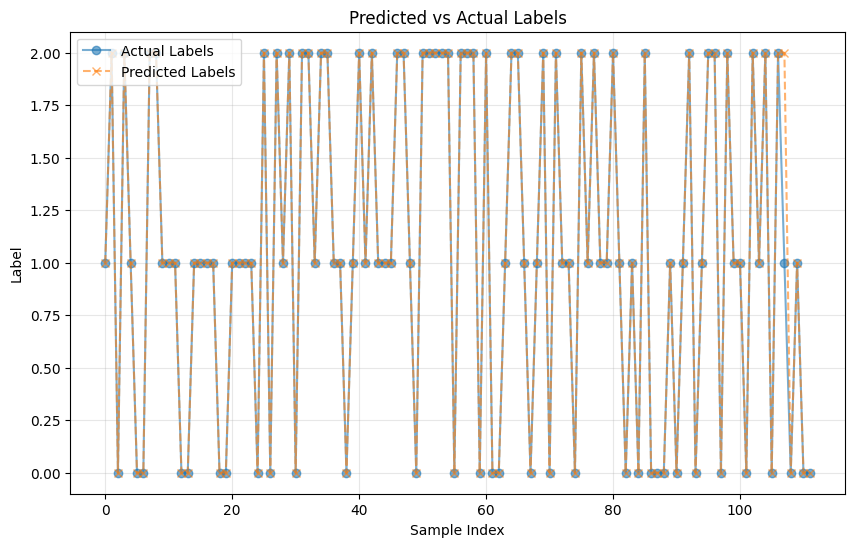

In [4]:
# ---------------------- Model Testing ----------------------

# Get one image from the test dataset and visualize
from random import randint
idx = randint(0, len(X_test) - 1)
sample = torch.tensor(X_test[idx], dtype=torch.float32)
true_label = y_test[idx]

# Inference phase
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations temporarily
    output = model(sample.unsqueeze(0))  # Add batch dimension
    predicted_label = output.argmax(dim=1).item()  # Get predicted label with max probability

print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

# For testing the overall accuracy
correct = 0
total = 0
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for i in range(len(X_test)):
        sample = torch.tensor(X_test[i], dtype=torch.float32)
        label = torch.tensor(y_test[i], dtype=torch.long)

        # Predict
        outputs = model(sample.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)

        total += 1
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# ---------------------- Plotting Results ----------------------

# For plotting the predictions vs. actual
pred_labels = []
for i in range(len(X_test)):
    sample = torch.tensor(X_test[i], dtype=torch.float32)
    output = model(sample.unsqueeze(0))
    pred_labels.append(output.argmax(dim=1).item())

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Labels', marker='o', linestyle='-', alpha=0.6)
plt.plot(range(len(pred_labels)), pred_labels, label='Predicted Labels', marker='x', linestyle='--', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Predicted vs Actual Labels')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Label distribution: 2    186
1    186
0    186
Name: count, dtype: int64


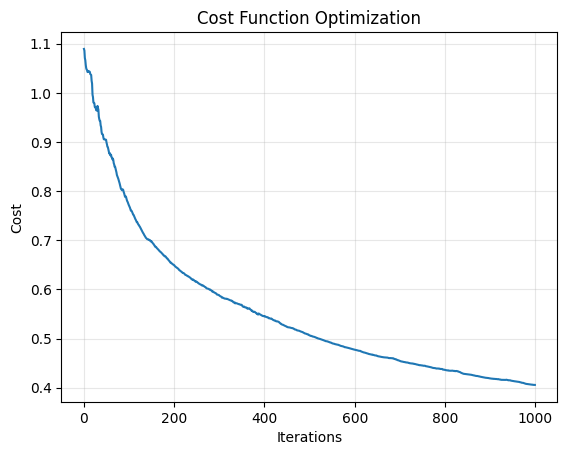

The logistic regression model parameters are: tensor([[-3.6355e-01, -1.5553e-01,  2.3329e-01,  3.1392e-01, -1.4027e+00],
        [ 4.7064e-01,  3.6370e-01, -2.3332e-01, -3.5222e-01, -8.5478e-02],
        [-1.0709e-01, -2.0817e-01,  2.6554e-05,  3.8296e-02,  1.4882e+00]])


In [7]:
# --------------- Logistic Regression ----------------------------
class log_reg:
    def __init__(self, num_features, num_classes):
        self.W = torch.zeros((num_classes, num_features))
        
    def prob(self, sample):
        x, y = sample
        x = torch.tensor([1] + x.tolist(), dtype=torch.float32)  # Add bias term
        z = torch.matmul(self.W, x)
        return self.softmax(z)
        
    def softmax (self, z):
        z = z - torch.max(z)
        exp_z = torch.exp(z)
        return exp_z/exp_z.sum()

    def grad(self, sample):
        x, y = sample
        x = torch.tensor([1] + x.tolist(), dtype=torch.float32)
        probs = self.prob((x[1:],y))

        y_onehot = torch.zeros_like(probs)
        y_onehot[y] = 1.0
        grad_W = torch.outer(probs - y_onehot, x)
        return grad_W

    def grad_update(self, sample, eta=0.00001):
        g = self.grad(sample)
        self.W -= eta * g

    def display(self):
        print(f"The logistic regression model parameters are: {self.W}")
        
    def cal_prob(self, x):
        if len(x.shape) == 1:
            x = np.insert(x, 0, 1)  # Add bias term
            x = torch.tensor(x, dtype=torch.float32)
            z = torch.matmul(self.W, x)
            return self.softmax(z)
        else:
            batch = []
            for row in x:
                tow = np.insert(row,0,1)
                row = torch.tensor(row, dtype=torch.float32)
                z = torch.matmul(self.W, row)
                prob_prob = self.softmax(z)
                batch.append(prob_prob)
            return torch.stack(batch)

# Initialize model
model = log_reg(num_features=5, num_classes = 3)
rows = X_train.shape[0]
iterations = 1000
cost_history = []

# Training
for i in range(iterations):
    num = random.randint(0, rows - 1)
    sample = (X_train[num], y_train[num])
    model.grad_update(sample, eta=0.01)

    # Cost calculation
    cost = 0
    for j in range(len(X_train)):
        sample = (X_train[j], y_train[j])
        prob = model.prob(sample)

        y_onehot = torch.zeros(len(prob))
        y_onehot[y_train[j]] = 1.0

        # Compute cross-entropy loss
        cost += -torch.sum(y_onehot * torch.log(prob + 1e-9))
        
    cost /= len(X_train)
    cost_history.append(cost.item())
print(f"Label distribution: {pd.Series(y_resampled).value_counts()}")

# Plot cost over iterations
plt.plot(range(iterations), cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Optimization')
plt.grid(alpha=0.3)
plt.show()

model.display()


Test Accuracy: 92.86%


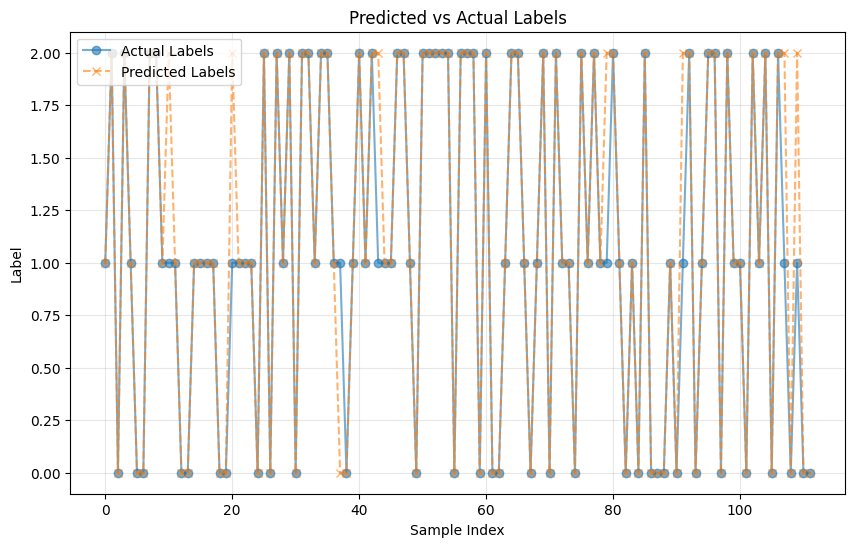

In [8]:
correct_predictions = 0
total_predictions = len(X_test)
pred_labels = []

for i in range(total_predictions):
    sample = X_test[i]
    probs = model.cal_prob(np.array(sample))  # Get the probability vector for the test sample

    # Determine the predicted label as the class with the highest probability
    pred_label = torch.argmax(probs).item()
    pred_labels.append(pred_label)

    # Check if the prediction is correct
    if pred_label == y_test[i]:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# --- Plot Predictions vs Actual ---
plt.figure(figsize=(10, 6))
plt.plot(range(total_predictions), y_test, label='Actual Labels', marker='o', linestyle='-', alpha=0.6)
plt.plot(range(total_predictions), pred_labels, label='Predicted Labels', marker='x', linestyle='--', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Predicted vs Actual Labels')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


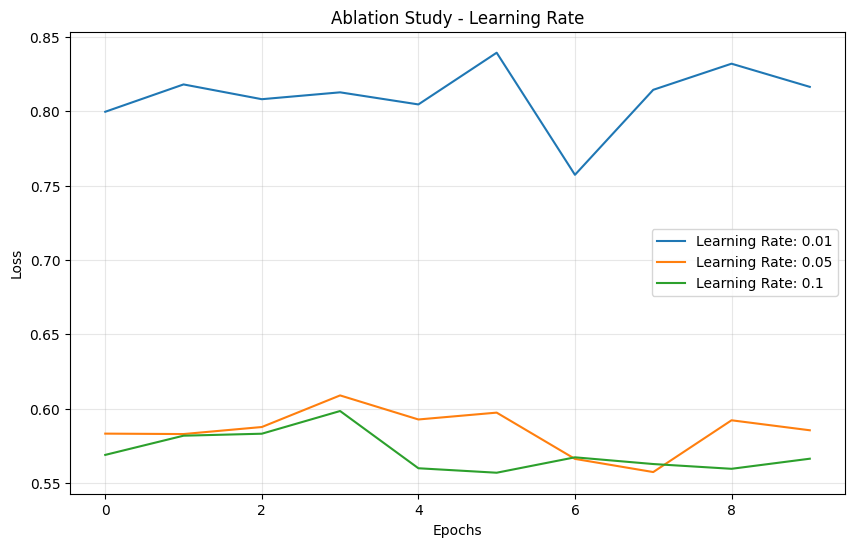

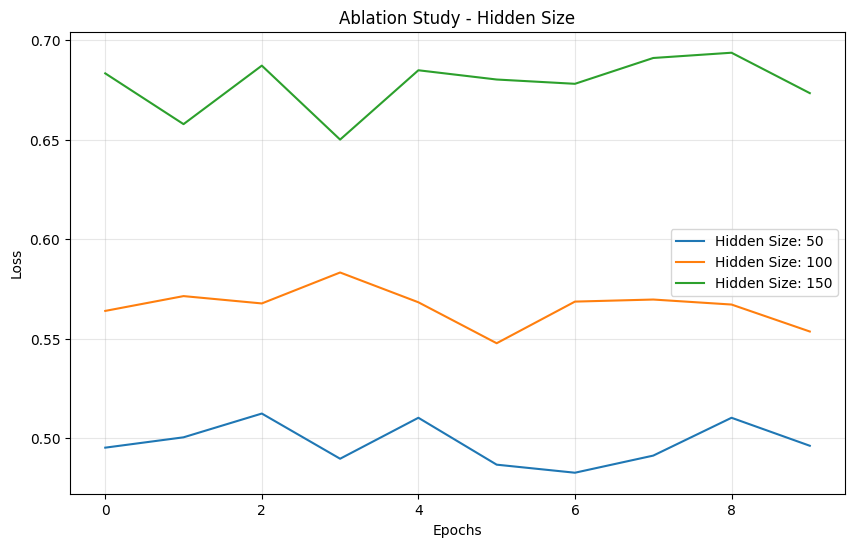

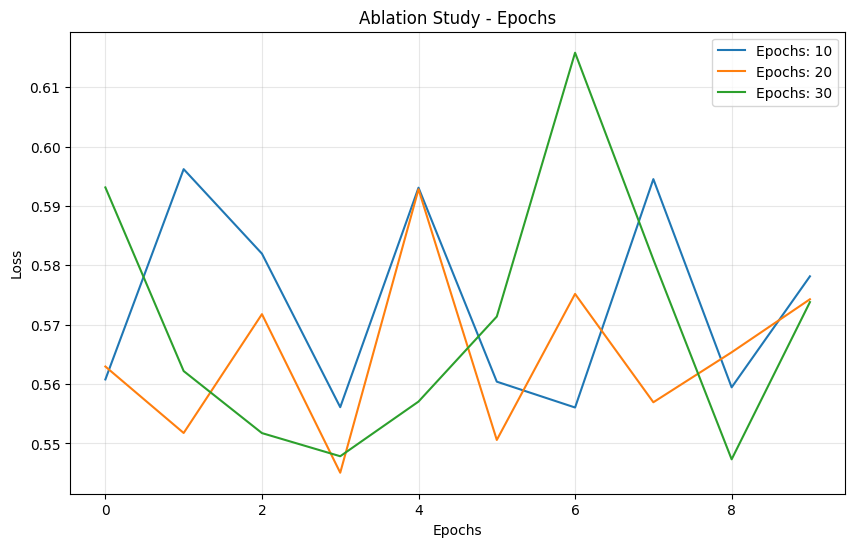

In [10]:
# Ablation Study
learning_rates = [0.01, 0.05, 0.1]
hidden_sizes = [50, 100, 150]
epochs_list = [10, 20, 30]

for param_name, param_values in zip(['Learning Rate', 'Hidden Size', 'Epochs'], [learning_rates, hidden_sizes, epochs_list]):
    plt.figure(figsize=(10, 6))
    for value in param_values:
        losses = []

        for epoch in range(10):  # Fixed epochs for consistency
            model = MLP(input_size=X_train.shape[1], hidden_size=100, output_size=3) if param_name != 'Hidden Size' else MLP(input_size=X_train.shape[1], hidden_size=value, output_size=3)
            optimizer = optim.SGD(model.parameters(), lr=0.1) if param_name != 'Learning Rate' else optim.SGD(model.parameters(), lr=value)
            criteria = nn.NLLLoss()

            running_loss = 0.0
            for i in range(len(X_train)):
                sample = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0)
                label = torch.tensor(y_train[i], dtype=torch.long).unsqueeze(0)
                optimizer.zero_grad()
                outputs = model(sample)
                loss = criteria(outputs, label)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(X_train)
            losses.append(avg_loss)

        plt.plot(range(10), losses, label=f"{param_name}: {value}")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Ablation Study - {param_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [3]:
# Ablation Study Parameters
learning_rates = [0.001, 0.01, 0.1]
iterations_lists = [500, 1000, 2000]
stopping_thresholds = [1e-3, 1e-4, 1e-5]

# Learning Rate Ablation Study
plt.figure()
for eta in learning_rates:
    cost_history = []
    model = log_reg(num_features=5, num_classes=3)
    for _ in range(1000):
        num = random.randint(0, len(X_train) - 1)
        sample = (X_train[num], y_train[num])
        model.grad_update(sample, eta=eta)

        cost = 0
        for i in range(len(X_train)):
            prob = model.prob((X_train[i], y_train[i]))
            y_onehot = torch.zeros(3)
            y_onehot[y_train[i]] = 1.0
            cost += -torch.sum(y_onehot * torch.log(prob + 1e-9))
        cost /= len(X_train)
        cost_history.append(cost.item())

    plt.plot(cost_history, label=f'LR: {eta}')
plt.title('Learning Rate Sensitivity - Logistic Regression')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Iteration Ablation Study
plt.figure()
for iters in iterations_lists:
    cost_history = []
    model = log_reg(num_features=5, num_classes=3)
    for _ in range(iters):
        num = random.randint(0, len(X_train) - 1)
        sample = (X_train[num], y_train[num])
        model.grad_update(sample, eta=0.01)

        cost = 0
        for i in range(len(X_train)):
            prob = model.prob((X_train[i], y_train[i]))
            y_onehot = torch.zeros(3)
            y_onehot[y_train[i]] = 1.0
            cost += -torch.sum(y_onehot * torch.log(prob + 1e-9))
        cost /= len(X_train)
        cost_history.append(cost.item())

    plt.plot(cost_history, label=f'Iterations: {iters}')
plt.title('Iterations Sensitivity - Logistic Regression')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

NameError: name 'log_reg' is not defined

<Figure size 640x480 with 0 Axes>